# Extracton of the preparatory and practice blocks from the preprocessed fif files

## 1. Importing libraries, data and removing bad channels

In [1]:
import mne
import pandas as pd
from pathlib import Path
import glob
import numpy as np
import os
import re          
import gc
from scipy import interpolate
import csv
import matplotlib.pyplot as plt

#Similar to the IAF extraction script, we load the csv containing the bad channels.
BAD_CSV = "/Users/lucas.assen/Desktop/Master Thesis/bad_channel_summary_2.csv"
bad_df = pd.read_csv(BAD_CSV,
                     sep=";",
                     engine="python",
                     quoting=csv.QUOTE_NONE).fillna("")

bad_df.columns = bad_df.columns.str.strip().str.lower()

# Again participant keys are created to line up the naming conventions of the partcpants included in the BAD_CSV and to the fif files.
bad_map = {}
for _, row in bad_df.iterrows():
    base = re.match(r"^0*?(\d+)", str(row["participant_id"])).group(1)
    suffix = "c" if str(row.get("group", "")).strip().lower().startswith("control") else ""
    key = f"{base}{suffix}"          
    bads = [ch for ch in str(row["bad_ch_names"]).split(",") if ch]
    bad_map[key] = bads


#Locating the preprocessed fif files and storing them in a list of fles
#Adapt the paths to your own file structure if needed.
buddhist_dir = Path("/Users/lucas.assen/Desktop/Master Thesis/Buddhists_preprocessed")
control_dir = Path("/Users/lucas.assen/Desktop/Master Thesis/Controls_preprocessed")

buddhist_fif_files = sorted(glob.glob(str(buddhist_dir / "*.fif")))
control_fif_files = sorted(glob.glob(str(control_dir / "*.fif")))


#Normalisng participant IDS to match them with the earlier created bad_map keys.
def norm_pid(pid_raw: str, condition: str) -> str:
    base = re.match(r"^0*?(\d+)", str(pid_raw)).group(1)
    suffix = "c" if condition.lower().startswith("control") else ""
    return f"{base}{suffix}"


#All files are loaded into a dictionary and in cases that a partcipant is loaded that according to the bad_map, has bad channels, has them removed.
D_0 = {"Buddhists": {}, "Controls": {}}

def load_data_files(file_list, condition):
    for file in file_list:
        pid_raw = Path(file).stem.split("_")[0]      
        pid = norm_pid(pid_raw, condition)               
        print(f"Currently loading {pid} ({condition})")

        raw = mne.io.read_raw_fif(file, preload=True, verbose="ERROR")

        bads = [ch for ch in bad_map.get(pid, []) if ch in raw.ch_names]
        if bads:
            print(f"{len(bads)} bad channels dropped: {bads}")
            raw.drop_channels(bads)

        D_0[condition][f"{pid}_RAW"] = raw

load_data_files(buddhist_fif_files, "Buddhists")
load_data_files(control_fif_files, "Controls")

Currently loading 10 (Buddhists)
3 bad channels dropped: ['M1', 'M2', 'SNz']
Currently loading 11 (Buddhists)
8 bad channels dropped: ['FT7', 'FC5', 'P10', 'M2', 'T7', 'P9', 'TP7', 'M1']
Currently loading 12 (Buddhists)
9 bad channels dropped: ['O1', 'M2', 'SNz', 'P9', 'AF8', 'Nz', 'Fp1', 'M1', 'Fp2']
Currently loading 13 (Buddhists)
5 bad channels dropped: ['Iz', 'M2', 'F7', 'M1', 'PO8']
Currently loading 14 (Buddhists)
4 bad channels dropped: ['P9', 'M1', 'M2', 'P10']
Currently loading 15 (Buddhists)
7 bad channels dropped: ['TP8', 'Iz', 'M2', 'SNz', 'T8', 'P9', 'M1']
Currently loading 16 (Buddhists)
7 bad channels dropped: ['Iz', 'O1', 'M2', 'SNz', 'T7', 'P9', 'M1']
Currently loading 1 (Buddhists)
18 bad channels dropped: ['F4', 'AF7', 'Iz', 'P10', 'O2', 'M2', 'F5', 'AF3', 'T7', 'P9', 'AF8', 'TP7', 'Fp1', 'Fpz', 'Nz', 'M1', 'PO8', 'Fp2']
Currently loading 2 (Buddhists)
8 bad channels dropped: ['P10', 'M2', 'AF4', 'T7', 'P9', 'AF8', 'TP7', 'M1']
Currently loading 3 (Buddhists)
5 bad 

## 2. Correction of the event markers & extraction of the practice and preparatory blocks.

In [ ]:
#An additional correction table is loaded for corrections on the block event markers as some of the blocks have incorrect markers.
#These are directly updated based on the correct markers found in the logfiles of the experiment,
CSV = "/Users/lucas.assen/Desktop/Master Thesis/block_corrections_final_2.csv"

#We created a corrections map wherby again the participant IDs are again normalised to match the keys of the fif files.
corr = (pd.read_csv(CSV).assign(group=lambda d: d.group.str.strip().replace({"Buddhist": "Buddhists", "Control" : "Controls"})))

def norm_pid(v: str) -> str:
    m = re.match(r"^0*?(\d+)(?:\.\d+)?([A-Za-z]*)$", str(v).strip())
    return (m.group(1) + m.group(2)) if m else str(v).strip()

corr["participant_id"] = corr["participant_id"].apply(norm_pid)
corr["block_idx"] = corr["block_idx"].astype(int)
corr_map = {(r.group, r.participant_id, r.block_idx): r.true_cond
            for r in corr.itertuples(index=False)}

#The following helper function allows for the strecthing of practice blocks shorter than 70 seconds to exactly 70 seconds using 1D linear interpolation.
#Blocks equal to or longer than 70 seconds return a raw.copy.
def stretch_raw_uniform(raw: mne.io.BaseRaw, target_sec=70.0):
    sf = raw.info["sfreq"]
    tgt = int(round(target_sec * sf))
    data = raw.get_data()
    n_ch, n_old = data.shape
    if n_old == tgt:
        return raw.copy()
    x_old = np.linspace(0, 1, n_old, endpoint=False)
    x_new = np.linspace(0, 1, tgt, endpoint=False)
    data2 = np.empty((n_ch, tgt), dtype=data.dtype)
    for c in range(n_ch):
        data2[c] = np.interp(x_new, x_old, data[c])
    return mne.io.RawArray(data2, raw.info.copy())


#The following function is used to extract and cut or interpolate the prep and practice blocks.
def extract_blocks(raw, group, raw_key):
    sf = raw.info["sfreq"]
    evt = mne.find_events(raw, "Status", initial_event=True, shortest_event=0)

    pid = norm_pid(re.match(r"(\d+)", raw_key).group(1) +
                   ("c" if group == "Controls" else ""))

    #We index the prep and practice blocks in pairs, so that the correct practice block can be matched to its prep block. 
    recs, pair_idx, i = [], 0, 0
    while i < len(evt):
        code = evt[i, 2]

        #Here the prep phases are extracted using their originial event markers, any mismatches with the corr_map are  corrected later.
        if code in (10, 11):
            pair_idx += 1
            blk_idx = pair_idx
            cond0 = "FA" if code == 10 else "LKM"
            expect = 99 if cond0 == "FA" else 100
            t0 = evt[i, 0] / sf
            j = i + 1
            while j < len(evt) and evt[j, 2] not in (expect, 200):
                j += 1
            t1 = evt[j, 0] / sf if j < len(evt) else raw.times[-1]

            recs.append(dict(kind="prep", group=group, participant_id=pid,
                             block_idx=blk_idx, default_cond=cond0,
                             rating=None,
                             duration=t1 - t0,
                             raw_orig = raw.copy().crop(t0, t1),
                             raw_70s = None,          
                             stretch_k=None))         
            i = j + 1 if (cond0 == "LKM" and evt[j, 2] == 200) else j
            continue

        #Here we extract the practice phases in similar fashion to the prep phases and is given the same pair index, which together stores them as a block.
        if code in (99, 100):
            cond0 = "FA" if code == 99 else "LKM"
            expect_pr = 199 if cond0 == "FA" else 200
            blk_idx = pair_idx                 
            t0 = evt[i, 0] / sf

            j = i + 1
            while j < len(evt) and evt[j, 2] != expect_pr:
                j += 1
            t1 = evt[j, 0] / sf if j < len(evt) else raw.times[-1]

            # Rating is stored as a seperate variable 
            k, rating = j + 1, None
            while k < len(evt):
                nxt = evt[k, 2]
                if nxt in (1, 2, 3):
                    rating, k = int(nxt), k + 1
                    break
                if nxt in (10, 11, 99, 100):
                    break
                k += 1

            # The corrected labels from the corr_map are used to update the original block condition labels.
            # afterwards, based on our studies exclusion criteria, we dropped blocks that were divine love (DL) or rated as 1.
            true_cond = corr_map.get((group, pid, blk_idx), cond0)
            if true_cond == "DL" or rating in (0, 1, None):
                recs = [r for r in recs
                        if not (r["participant_id"] == pid and
                                r["block_idx"] == blk_idx)]
                i = k
                continue

            # Next the durtions of the practice blocks are determined. For blocks shorter than 70 seconds a stretch factor is calculated and stored as a variable and the block is stretched.
            # Blocks longer than 70 seconds are trimmed and the strech factor is set to 1.0.
            pr_raw_orig = raw.copy().crop(t0, t1)
            dur_orig = t1 - t0
            if dur_orig < 70.0:                           
                stretch_k = 70.0 / dur_orig
                pr_raw_70 = stretch_raw_uniform(pr_raw_orig, 70.0)
            else:                                         
                stretch_k = 1.0
                pr_raw_70 = pr_raw_orig.copy().crop(tmax=70.0, include_tmax=False)

            # The prep phases that are paired with practice phases that were stretched are also stretched using the same factor.
            # if, as a result of using the same stretch factor the prep phase exceeds 70 seconds, it is trimmed to 70 seconds.
            if stretch_k > 1.0:                         
                for r in recs:
                    if (r["kind"] == "prep" and
                        r["participant_id"] == pid and
                        r["block_idx"] == blk_idx):
                        orig_len  = r["duration"]                
                        new_len = orig_len * stretch_k        
                        
                        if new_len > 70.0:                      
                            new_len = 70.0

                        r["raw_70s"] = stretch_raw_uniform(r["raw_orig"], new_len)
                        r["stretch_k"] = stretch_k             
                        r["duration"] = new_len               
                        break
            else:                                         
                for r in recs:
                    if (r["kind"] == "prep" and
                        r["participant_id"] == pid and
                        r["block_idx"] == blk_idx and
                        r["raw_70s"] is None):
                        r["raw_70s"] = r["raw_orig"]
                        r["stretch_k"] = 1.0
                        break
            
            # Lastly, all variables related to each practice block are stored in a dictionary and appended to a list of records.
            recs.append(dict(kind="practice", group=group, participant_id=pid,
                             block_idx=blk_idx, default_cond=cond0,
                             rating=rating, duration=70.0,
                             raw_orig = pr_raw_orig,
                             raw_70s = pr_raw_70,
                             stretch_k = stretch_k))
            i = k
            continue
        i += 1
    return recs

# Ultimately, the output of the extraction function is stored per participant in a complete list.
all_segments = []

# To do so the extraction function is iterated over all participants in the D_0 dictionary.
for grp, subs in D_0.items():
    for key, raw in subs.items():
        for seg in extract_blocks(raw, grp, key):

            final_cond = corr_map.get((seg["group"], seg["participant_id"], seg["block_idx"]),seg["default_cond"])

            # Here all relevant variables are stored and appended to the complete list.
            all_segments.append({"group": seg["group"],
                                 "participant_id": seg["participant_id"],
                                 "block_idx": seg["block_idx"],
                                 "kind": seg["kind"],      
                                 "cond": final_cond,           
                                 "duration_s": seg["duration"],
                                 "rating": seg["rating"],
                                 "stretch_k": seg.get("stretch_k", 1.0), 
                                 "raw_orig": seg["raw_orig"],
                                 "raw_70s": seg["raw_70s"] or seg["raw_orig"],})

#Lastly, we put in an extra check to ensure that all prep blocks have a corresponding practice block.
#In case a prep block is on its own it is removed from the complete list.
have_practice = {(s["participant_id"], s["block_idx"])
                 for s in all_segments
                 if s["kind"] == "practice"}

all_segments = [s for s in all_segments
                if not (s["kind"] == "prep"
                        and (s["participant_id"], s["block_idx"])
                           not in have_practice)]
                           
print(f"Done, {len(all_segments)} segments extracted")

## 3. Visually inspecting the extracted blocks to show the dilation effect of the linear interpolation.

Block with largest dilation:
Original length: 47.74 s
Length after dilation: 70.00 s
Using pyopengl with version 3.1.9
Using pyopengl with version 3.1.9


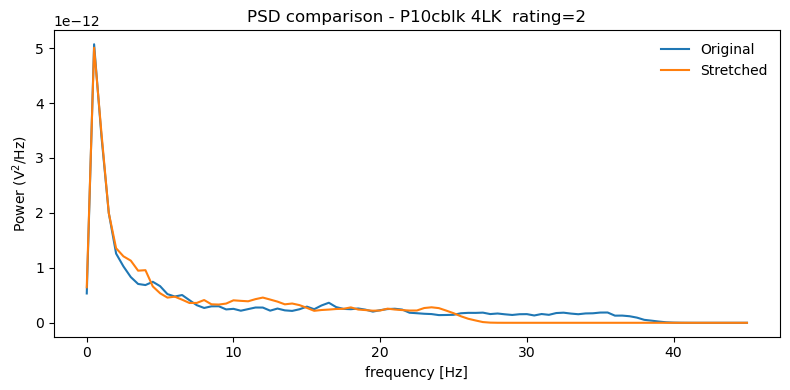

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
# To display the elongated blocks we first have to identify the blocks that have been stretched, preferably by comparing their original durations.
# The following helper function helps recalculate the original duration of a block in seconds.
def get_orig_len(seg):
    raw_o = seg["raw_orig"]
    return raw_o.n_times / raw_o.info["sfreq"]

# Next we identify all stretched practice blocks by those whoms original durations are shorter than 70 seconds.
# The shortest of these blocks, i.e., the one with the largest stretch factor, is selected for demonstration.
# A failsafe is included to raise an error in case no stretched blocks are found, though this should not happen.
stretch_cands = [s for s in all_segments
                 if s["kind"] == "practice" and get_orig_len(s) < 70.0 - 1e-3]

if not stretch_cands:
    raise RuntimeError("No stretched blocks found")

seg_demo = max(stretch_cands,
               key=lambda s: 70.0 - get_orig_len(s))
raw_orig = seg_demo["raw_orig"]       
raw_70s  = seg_demo["raw_70s"]        

# Relevant info about the block is stored and printed.
info_str = (f"P{seg_demo['participant_id']}"
            f"blk {seg_demo['block_idx']}"
            f"{seg_demo['cond']}  rating={seg_demo['rating']}")

print(f"Block with largest dilation:\n"
      f"Original length: {get_orig_len(seg_demo):.2f} s\n"
      f"Length after dilation: 70.00 s")

# In the following two plots we display the original and stretched version of the block that had the highest stretch factor.
# This helps for a good side by side comparison of the signal pre and post dilation in the most extreme case.
raw_orig.plot(title=f"{info_str} Original ({get_orig_len(seg_demo):.2f} s)",       
              start=0.0,           
              duration=9.0,         
              scalings="auto",
              butterfly=False,
              show=True,
              block=False,)

raw_70s.plot(title=f"{info_str} Stretched (70 s, first 9 s shown)",        
             start=0.0,            
             duration=9.0,         
             scalings="auto",
             butterfly=False,
             show=True,
             block=False,)

# Next, we created a overlay of the power spectral densities (PSDs) of both the original and stretched version of the block.
fmax_psd = 45.0 
psd_o  = raw_orig.compute_psd(fmax=fmax_psd, verbose=False)
psd_70 = raw_70s .compute_psd(fmax=fmax_psd, verbose=False)
freqs = psd_o.freqs
pow_o  = psd_o .get_data().mean(axis=0)   
pow_70 = psd_70.get_data().mean(axis=0)
fig, ax_p = plt.subplots(figsize=(8, 4))
ax_p.plot(freqs, pow_o, label="Original")
ax_p.plot(freqs, pow_70, label="Stretched")
ax_p.set(xlabel="frequency [Hz]",
         ylabel=r"Power (V$^2$/Hz)",
         title=f"PSD comparison - {info_str}",)
ax_p.legend(frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
# After properly extracting all prep and practice blocks D_0 is emptied and removed to free up memory.
for condition in list(D_0):
    for participant, raw in D_0[condition].items():
        raw.close()            
    D_0[condition].clear()
del D_0
gc.collect()

## 4. Saving and checking the extracted blocks.

In [ ]:
# The file path should be changed into your own file structure.
# an event id is created to seperate 
OUT_DIR = "/Users/lucas.assen/Desktop/Master Thesis/sub_epoch_files_2"
os.makedirs(OUT_DIR, exist_ok=True)
event_id = {"prep": 1, "practice": 2}

def raw_to_use(seg):
    return seg["raw_70s"]

# Each participant is stored in a fif with the included epochs of their prep and practice blocks and the relevant metadata.
participants = sorted({s["participant_id"] for s in all_segments})
for pid in participants:
    segs = [s for s in all_segments if s["participant_id"] == pid]
    if not segs:
        continue

    #The metadata is stored as a pandas df, excluding the raw objects
    meta = pd.DataFrame([{k: v for k, v in s.items() if k not in ("raw_orig", "raw_70s")}
                         for s in segs])

    #The info of the raw object is extracted to create the MNE info object.
    ref_raw = raw_to_use(segs[0])
    sfreq = ref_raw.info["sfreq"]
    ch_names = ref_raw.info["ch_names"]
    ch_types = ref_raw.get_channel_types()

    # The longest segment is determined to ensure that the data cube can accomodate all segments.
    # This should be 70 seconds as all segments have been trimmed or stretched to this length.
    max_len = max(raw_to_use(s).n_times for s in segs)

    # The data cube and events array are created.
    n_ep = len(segs)
    data = np.zeros((n_ep, len(ch_names), max_len), dtype=np.float32)
    events = np.zeros((n_ep, 3), dtype=int)

    # The epoch are copied into the data events array
    for idx, seg in enumerate(segs):
        raw = raw_to_use(seg).copy().pick(ch_names).load_data()
        n_t = raw.n_times
        data[idx, :, :n_t] = raw.get_data()
        events[idx]        = [idx, 0, event_id[seg["kind"]]]
        raw.close()

    # The epochs array is created and savedcombining the event data cube and metadata/info on the epochs.
    info   = mne.create_info(ch_names, sfreq, ch_types)
    epochs = mne.EpochsArray(data, info,
                             events = events,
                             event_id  = event_id,
                             tmin      = 0.0,
                             metadata  = meta)

    fout = os.path.join(OUT_DIR, f"sub-{pid}_segments-epo.fif")
    epochs.save(fout, overwrite=True)
    print(f"{pid}: stored {n_ep} epochs in the fif file")

    # Again memory is cleared after each participant, to make it easier to run.
    del epochs, data, events, meta
    gc.collect()

In [ ]:
# After saving the extracted prep and practice epochs we can load a participant's epochs file to inspect the metadata and the epochs themselves. 
# Change the file path approapriately to point to the partcipant you want to inspect.
 
FILE = Path("/Users/lucas.assen/Desktop/Master Thesis/sub_epoch_files")
FILE = FILE / "sub-1_segments-epo.fif"       

# The file is loaded and a header of the meta data including additional information about the participant and block types is printed.
epoch = mne.read_epochs(FILE, preload=False, verbose="error")
meta = epoch.metadata          

print(f"\nFile :  {FILE.name}")
print(f"sfreq:  {epoch.info['sfreq']} Hz")
print(f"epochs: {len(epoch)}  |  channels: {len(epoch.ch_names)}")
print("Counts (kind x cond):")
print(meta.groupby(["kind", "cond"]).size().unstack(fill_value=0))
print("\nMetadata:")
display(meta.head())

# Following the inspection of the metadata, the prep and practice blocks of the selected participant can be plotted to visually confirm that they are correctly extracted.
# Currently, the first prep and adhering practce block are plotted, change the indexes if you want to see other blocks.
idx_prep     = meta.query("kind=='prep'").index[0]
idx_practice = meta.query("kind=='practice'").index[0]
print("\nPlot of first prep epoch")
epoch[idx_prep].plot(title=f"{FILE.stem} - first prep epoch")
print("\nPlot of first practice epoch")
epoch[idx_practice].plot(title=f"{FILE.stem} - first practice block")